# Optimising Python using Conway's Game of Life

In this tutorial we look at some techniques for optimising Python code for speed. To do so we will use Conway's Game of Life (GoL) as a test case. The GoL is a cellular automaton that obeys four simple rules:

1. Any live cell with fewer than two live neighbours dies, as if caused by underpopulation.
2. Any live cell with two or three live neighbours lives on to the next generation.
3. Any live cell with more than three live neighbours dies, as if by overpopulation.
4. Any dead cell with exactly three live neighbours becomes a live cell, as if 

To implement the GoL we will require two basic peices of code:
- Code to find the number of live neighbours each cell has
- Code to update each cell based on its number of neighbours

In psuedo code terms the GoL looks like:

```
create "board" of cells
for generation in generations:
    calculate number of live neighbours on each cell
    update each cell based on the GoL rules
```    


In [1]:
#The following code to enable animation embedding is borrowed from
#http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
#Note: requires either ffmpeg or mencoder to run

%pylab inline
from tempfile import NamedTemporaryFile
from IPython.display import HTML
from matplotlib import animation

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

Populating the interactive namespace from numpy and matplotlib


## Test harness

In [2]:
def game_of_life(board, 
                 niterations,
                 find_neighbours_func, 
                 update_board_func
                ):
    #capture what the initial board looks like
    images = [[plt.imshow(board, interpolation='nearest', cmap='binary')]]
    #loop through niterations generations of the game
    for _ in range(niterations):
        neighbours = find_neighbours_func(board)
        board = update_board_func(board, neighbours)
        #plot the board after each generation
        images.append([plt.imshow(board, interpolation='nearest', cmap='binary')])
    ani = animation.ArtistAnimation(plt.gcf(), images, interval=5, blit=True, repeat=False)
    return display_animation(ani)

#To give a standard speed tests, all codes will process the test board:
test_board = np.zeros([300,300], dtype='int32')

#As a test the following can be used to generate an input
display_board = lambda: np.random.randint(0, 2, [40,40], dtype='int32')

def display_timings(result):
    print "Timing over {} loops".format(result.loops)
    print "Best time: %.04f ms"%(result.best*1000)
    print "Worst time: %.04f ms"%(result.worst*1000)
    print "Mean time: %.04f ms"%(np.mean(result.all_runs)*1000)
    print "First run: %.04f ms"%(result.all_runs[0])
    print "Mean excluding first: %.04f ms\n"%(np.mean(result.all_runs[1:])*1000)
    plt.plot(result.all_runs)
    plt.xlabel("Run number")
    plt.ylabel("Time")
 

## Pure Python

In [3]:
def find_neighbours_pp(board):
    nrows, ncols = board.shape
    neighbours = np.zeros_like(board)
    for row in range(nrows):
        for col in range(ncols):
            for ii in [-1,0,1]:
                for jj in [-1,0,1]:
                    if ii==0 and jj==0:
                        continue
                    else:
                        neighbours[row][col] += board[(row+ii)%nrows][(col+jj)%ncols]
    return neighbours

def update_board_pp(board, neighbours):
    nrows, ncols = board.shape
    for row in range(nrows):
        for col in range(ncols):
            if board[row][col] == 1:
                if (neighbours[row][col] < 2) or (neighbours[row][col] > 3):
                    board[row][col] = 0
            else:
                if (neighbours[row][col] == 3):
                    board[row][col] = 1
    return board

In [4]:
game_of_life(display_board(), 100, find_neighbours_pp, update_board_pp)

1 loop, best of 5: 958 ms per loop
Timing over 1 loops
Best time: 957.7050 ms
Worst time: 1099.6349 ms
Mean time: 976.2198 ms
First run: 0.9903 ms
Mean excluding first: 972.6940 ms

1 loop, best of 5: 284 ms per loop
Timing over 1 loops
Best time: 284.1949 ms
Worst time: 358.6020 ms
Mean time: 289.5284 ms
First run: 0.2846 ms
Mean excluding first: 290.7683 ms



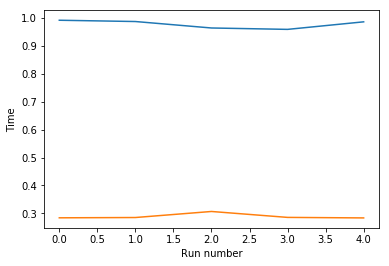

In [5]:
#Test speed
fn_pp = %timeit -o -r 5 find_neighbours_pp(test_board)
display_timings(fn_pp)
ub_pp = %timeit -o -r 5 update_board_pp(test_board, test_board)
display_timings(ub_pp)

## Pure Python + Numba 

In [6]:
from numba import jit

@jit
def find_neighbours_numba(board):
    nrows, ncols = board.shape
    neighbours = np.zeros_like(board)
    for row in range(nrows):
        for col in range(ncols):
            for ii in [-1,0,1]:
                for jj in [-1,0,1]:
                    if ii==0 and jj==0:
                        continue
                    else:
                        neighbours[row][col] += board[(row+ii)%nrows][(col+jj)%ncols]
    return neighbours

@jit
def update_board_numba(board, neighbours):
    nrows, ncols = board.shape
    for row in range(nrows):
        for col in range(ncols):
            if board[row][col] == 1:
                if (neighbours[row][col] < 2) or (neighbours[row][col] > 3):
                    board[row][col] = 0
            else:
                if (neighbours[row][col] == 3):
                    board[row][col] = 1
    return board

#to force precompilation we will call both functions here
null = find_neighbours_numba(test_board)
null = update_board_numba(test_board,test_board)

In [7]:
game_of_life(display_board(), 100, find_neighbours_numba, update_board_numba)

10 loops, best of 10: 114 ms per loop
Timing over 10 loops
Best time: 113.5129 ms
Worst time: 168.0350 ms
Mean time: 1244.2159 ms
First run: 1.2940 ms
Mean excluding first: 1238.6806 ms

10000 loops, best of 10: 92 µs per loop
Timing over 10000 loops
Best time: 0.0920 ms
Worst time: 0.0992 ms
Mean time: 924.4776 ms
First run: 0.9218 ms
Mean excluding first: 924.7750 ms



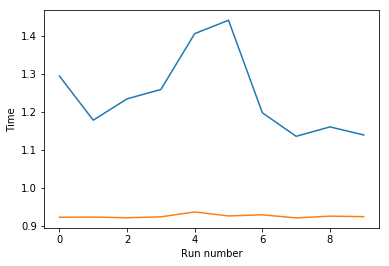

In [8]:
#Test speed
fn_nb = %timeit -o -r 10 find_neighbours_numba(test_board)
display_timings(fn_nb)
ub_nb = %timeit -o -r 10 update_board_numba(test_board, test_board)
display_timings(ub_nb)

## NumPy

In [10]:
def find_neighbours_numpy(board):
    neighbours = np.zeros_like(board)
    steps = [-1,0,1]
    for a in steps:
        for b in steps:
            if (a,b) != (0,0):
                neighbours += np.roll(np.roll(board,a,axis=0),b,axis=1)
    return neighbours

def update_board_numpy(board, neighbours):
    set_zero_idxs = (board==1) & ((neighbours<2) | (neighbours>3))
    set_one_idxs = (board!=1) & (neighbours==3)
    board[set_zero_idxs] = 0
    board[set_one_idxs] = 1
    return board

In [11]:
game_of_life(display_board(), 100, find_neighbours_numpy, update_board_numpy)

1000 loops, best of 30: 1.1 ms per loop
Timing over 1000 loops
Best time: 1.1033 ms
Worst time: 2.9409 ms
Mean time: 1117.4340 ms
First run: 1.1082 ms
Mean excluding first: 1117.7535 ms

1000 loops, best of 30: 248 µs per loop
Timing over 1000 loops
Best time: 0.2478 ms
Worst time: 0.4990 ms
Mean time: 261.3510 ms
First run: 0.2556 ms
Mean excluding first: 261.5503 ms



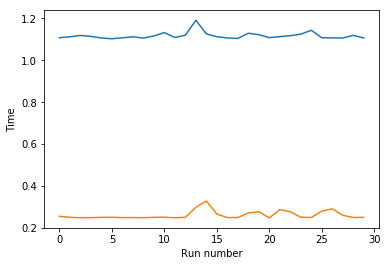

In [12]:
#Test speed
fn_np = %timeit -o -r 30 find_neighbours_numpy(test_board)
display_timings(fn_np)
ub_np = %timeit -o -r 30 update_board_numpy(test_board, test_board)
display_timings(ub_np)

## Weave

In [13]:
import weave

def find_neighbours_weave(board, force=0):
    ny, nx = board.shape
    neighbours = np.zeros_like(board)
    code = """
    for (int ii=0; ii < ny; ++ii)
    {
        for (int jj=0; jj < nx; ++jj)
        {
            if ((ii==0) || (ii==ny-1) || (jj==0) || (jj==nx-1))
            {
                for (int kk=-1; kk<=1; ++kk)
                {
                    for (int ll=-1; ll<=1; ++ll)
                    {
                    if (!((kk==0) && (ll==0)))
                        neighbours(ii,jj) += board((ii+kk)%ny,(jj+ll)%nx);
                    }
                }
            }
            else
            {
               for (int kk=-1; kk<=1; ++kk)
                {
                    for (int ll=-1; ll<=1; ++ll)
                    {
                        if (!((kk==0) && (ll==0)))
                            neighbours(ii,jj) += board((ii+kk),(jj+ll));
                    }
                }
            }
        }
    }
    """
    weave.inline(code,['neighbours', 'board', 'nx', 'ny'],
                 type_converters = weave.converters.blitz,
                 compiler = 'gcc',
                 force=force)
    return neighbours

#precompile
null = find_neighbours_weave(test_board, force=1)

In [14]:
game_of_life(display_board(), 100, find_neighbours_weave, update_board_numpy)

1000 loops, best of 30: 1.39 ms per loop
Timing over 1000 loops
Best time: 1.3928 ms
Worst time: 2.6195 ms
Mean time: 1511.7630 ms
First run: 1.4706 ms
Mean excluding first: 1513.1820 ms



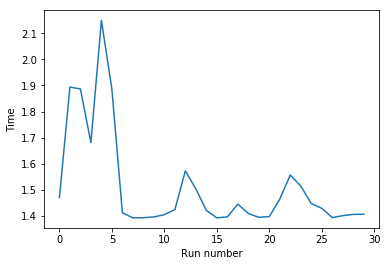

In [18]:
#Test speed
fn_weave = %timeit -o -r 30 find_neighbours_weave(test_board)
display_timings(fn_weave)

## Comparison

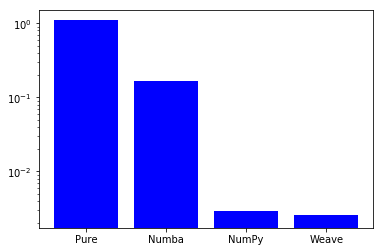

In [19]:
results = [fn_pp, fn_nb, fn_np, fn_weave]
worsts = np.array([i.worst for i in results])

fig = plt.figure()
ax = fig.add_subplot(111)
ind = np.arange(4)
width = 1
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Pure', 'Numba', 'NumPy', 'Weave'))
rects1 = ax.bar(range(4), worsts, 0.8, color='b', log=True)
plt.show()

## NumPy vs. Weave scaling

In [20]:
np_results = []
weave_results = []

sizes = np.logspace(2,4,6).astype('int32')
for size in sizes:
    board = np.zeros([size,size],dtype='int32')
    np_result = %timeit -o -r 5 find_neighbours_numpy(board)
    np_results.append(np_result)
    weave_result = %timeit -o -r 5 find_neighbours_weave(board)
    weave_results.append(weave_result)


1000 loops, best of 5: 328 µs per loop
10000 loops, best of 5: 164 µs per loop
1000 loops, best of 5: 843 µs per loop
1000 loops, best of 5: 973 µs per loop
100 loops, best of 5: 6.48 ms per loop
100 loops, best of 5: 6.04 ms per loop
10 loops, best of 5: 79.4 ms per loop
10 loops, best of 5: 40.1 ms per loop
1 loop, best of 5: 487 ms per loop
1 loop, best of 5: 255 ms per loop
1 loop, best of 5: 4.65 s per loop
1 loop, best of 5: 1.69 s per loop


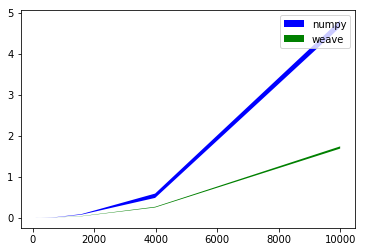

In [21]:
def plot_curve(results,label,colour):
    best = [i.best for i in results]
    worst = [i.worst for i in results]
    plt.fill_between(sizes,worst,best,facecolor=colour,label=label)

plot_curve(np_results,"numpy","b")
plot_curve(weave_results,"weave","g")
plt.legend()

In [22]:
PATTERNS = {}

PATTERNS["glider_gun"] =\
[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

PATTERNS["diehard"] = [[0, 0, 0, 0, 0, 0, 1, 0],
           [1, 1, 0, 0, 0, 0, 0, 0],
           [0, 1, 0, 0, 0, 1, 1, 1]]

PATTERNS["boat"] = [[1, 1, 0],
        [1, 0, 1],
        [0, 1, 0]]

PATTERNS["r_pentomino"] = [[0, 1, 1],
               [1, 1, 0],
               [0, 1, 0]]

PATTERNS["beacon"] = [[0, 0, 1, 1],
          [0, 0, 1, 1],
          [1, 1, 0, 0],
          [1, 1, 0, 0]]

PATTERNS["acorn"] = [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [1, 1, 0, 0, 1, 1, 1]]

PATTERNS["spaceship"] = [[0, 0, 1, 1, 0],
             [1, 1, 0, 1, 1],
             [1, 1, 1, 1, 0],
             [0, 1, 1, 0, 0]]

PATTERNS["block_switch_engine"] = [[0, 0, 0, 0, 0, 0, 1, 0],
                       [0, 0, 0, 0, 1, 0, 1, 1],
                       [0, 0, 0, 0, 1, 0, 1, 0],
                       [0, 0, 0, 0, 1, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0, 0, 0],
                       [1, 0, 1, 0, 0, 0, 0, 0]]

PATTERNS["glider"] = [[1, 0, 0],
          [0, 1, 1],
          [1, 1, 0]]

PATTERNS["pulsar"] = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [23]:
def init(size, pattern=None):
    assert len(size) == 2, "size parameter must be a 2-tuple"
    if pattern is None:
        board = np.random.randint(0,2,size).astype('int32')
    else:
        pattern = np.asarray(pattern)
        board = np.zeros(size,dtype='int32')
        assert board.shape[0] > pattern.shape[0], "pattern has more rows than board"
        assert board.shape[1] > pattern.shape[1], "pattern has more columns than board"
        row_margin = (board.shape[0] - pattern.shape[0])/2
        col_margin = (board.shape[1] - pattern.shape[1])/2
        board[row_margin:row_margin+pattern.shape[0],col_margin:col_margin+pattern.shape[1]] = pattern
    return board.astype('int32')

In [24]:
board = init([100,100],PATTERNS['glider_gun'])

In [25]:
game_of_life(board, 100, find_neighbours_weave, update_board_numpy)